In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
from geopy.distance import vincenty
from matplotlib import ticker
from NFLFunctions import *
from string import digits
import scipy.optimize as optimization
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def const(x, a):
    return a

In [3]:
def line(x, a, b):
    return b * x + a

In [4]:
scores = pd.read_csv('/Users/dekedor/Programming/Kaggle/iPythonNotebooks/NFLDB/NFL_Data_DataFrame_V1.csv')

In [5]:
dists = scores[(scores['TravelDistance'].notnull()) & (scores['Season'] >= 1966) & \
               (scores['Playoffs?'] == False)]['TravelDistance'].values
scores_diffs = scores[scores['TravelDistance'].notnull() & (scores['Season'] >= 1966) & \
                      (scores['Playoffs?'] == False)]['ScoreDiff'].values

In [6]:
bins = [0, 200, 400, 600, 800, 1000, 1200, 1600, 2000, 3000]
dist_bin = np.digitize(dists, bins)
dist_centers = np.array([np.mean(dists[dist_bin == i]) for i in range(1, len(bins))])
dist_score_diffs = np.array([np.mean(scores_diffs[dist_bin == i]) for i in range(1, len(bins))])
dist_score_diffs_err = np.array([np.std(scores_diffs[dist_bin == i])/np.sqrt(len(scores_diffs[dist_bin == i])) \
                                                                             for i in range(1, len(bins))])

In [7]:
dist_home_win_per = 100. * \
np.array([np.sum(scores_diffs[dist_bin == i] > 0.)/len(scores_diffs[dist_bin == i]) for i in range(1, len(bins))])
dist_home_win_per_err = 100. * \
np.array([sqrt((np.sum(scores_diffs[dist_bin == i] > 0.)/(len(scores_diffs[dist_bin == i])**2) + \
               (np.sum(scores_diffs[dist_bin == i] > 0.)**2/(len(scores_diffs[dist_bin == i])**3)))) \
         for i in range(1, len(bins))])

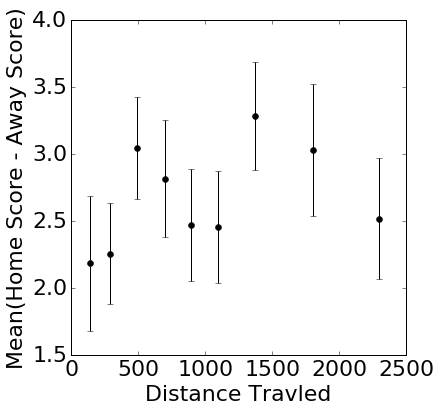

In [8]:
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
plt.errorbar(dist_centers, dist_score_diffs, yerr=dist_score_diffs_err, fmt='ko')
xlabel('Distance Travled')
ylabel('Mean(Home Score - Away Score)')

(40, 65)

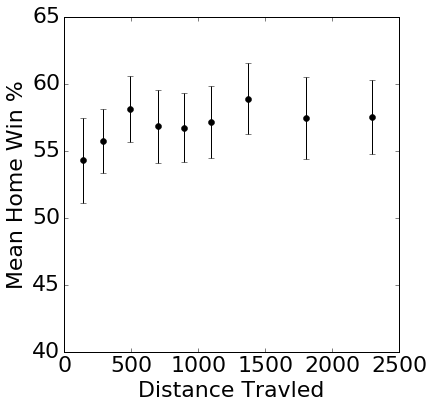

In [9]:
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
plt.errorbar(dist_centers, dist_home_win_per, yerr=dist_home_win_per_err, fmt='ko')
xlabel('Distance Travled')
ylabel('Mean Home Win %')
ylim([40, 65])

In [10]:
scores['HomeTeam'] = np.array(['Arizona Cardinals' if team == 'Phoenix Cardinals' else \
                    'New England Patriots' if team == 'Boston Patriots' else 'Tennessee Titans' if \
                    team == 'Tennessee Oilers'  else team for team in scores['HomeTeam']])
scores['AwayTeam'] = np.array(['Arizona Cardinals' if team == 'Phoenix Cardinals' else \
                    'New England Patriots' if team == 'Boston Patriots' else 'Tennessee Titans' if \
                    team == 'Tennessee Oilers'  else team for team in scores['AwayTeam']])

In [11]:
dist_dfs = [GetScoresDistRange(scores, bins[i], bins[i + 1], season_min = 1966, playoffs = False) \
            for i in range(len(bins) - 1)]
dist_dfs.append(GetScoresDistRange(scores, 0., 3000., season_min = 1966, playoffs = False))

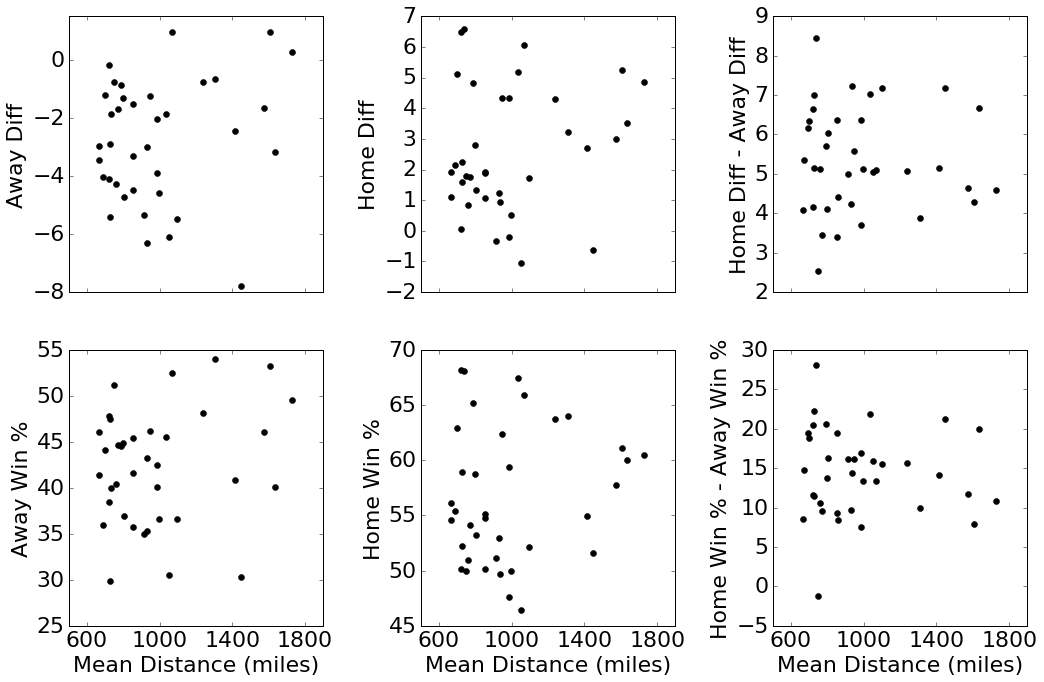

In [16]:
f, axarr = plt.subplots(2, 3, figsize=(15, 10), sharex = 'col')
mpl.rcParams.update({'font.size': 22})
axarr[0, 0].plot(dist_dfs[-1]['MeanDistance'].values, dist_dfs[-1]['AwayDiff'].values, 'ko')
axarr[0, 0].set_ylabel('Away Diff')
axarr[0, 0].set_ylim([-8, 1.5])
axarr[1, 0].plot(dist_dfs[-1]['MeanDistance'].values, dist_dfs[-1]['%AwayW'].values, 'ko')
axarr[1, 0].set_ylabel('Away Win %')
axarr[1, 0].set_xlim([500, 1900])
axarr[1, 0].xaxis.set_ticks([600, 1000, 1400, 1800])
axarr[1, 0].set_xlabel('Mean Distance (miles)')
axarr[0, 1].plot(dist_dfs[-1]['MeanDistance'].values, dist_dfs[-1]['HomeDiff'].values, 'ko')
axarr[0, 1].set_ylabel('Home Diff')
axarr[1, 1].plot(dist_dfs[-1]['MeanDistance'].values, dist_dfs[-1]['%HomeW'].values, 'ko')
axarr[1, 1].set_xlabel('Mean Distance (miles)')
axarr[1, 1].set_ylabel('Home Win %')
axarr[1, 1].set_xlim([500, 1900])
axarr[1, 1].xaxis.set_ticks([600, 1000, 1400, 1800])
axarr[1, 1].set_xlabel('Mean Distance (miles)')
axarr[0, 2].plot(dist_dfs[-1]['MeanDistance'].values, dist_dfs[-1]['HomeDiff - AwayDiff'].values, 'ko')
axarr[0, 2].set_xlim([500, 1900])
axarr[0, 2].xaxis.set_ticks([600, 1000, 1400, 1800])
axarr[0, 2].set_ylabel('Home Diff - Away Diff')
axarr[1, 2].plot(dist_dfs[-1]['MeanDistance'].values, dist_dfs[-1]['%Home - %Away'].values, 'ko')
axarr[1, 2].set_ylabel('Home Win % - Away Win %')
axarr[1, 2].set_xlim([500, 1900])
axarr[1, 2].xaxis.set_ticks([600, 1000, 1400, 1800])
axarr[1, 2].set_xlabel('Mean Distance (miles)')
plt.tight_layout()

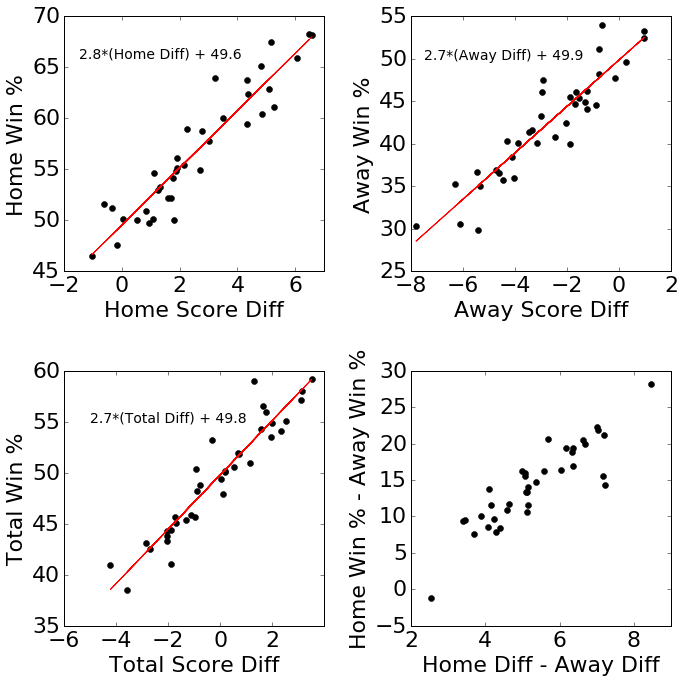

In [15]:
f, axarr = plt.subplots(2, 2, figsize=(10, 10))
mpl.rcParams.update({'font.size': 22})
axarr[0, 0].plot(dist_dfs[-1]['HomeDiff'].values, dist_dfs[-1]['%HomeW'].values, 'ko')
axarr[0, 0].set_xlabel('Home Score Diff')
axarr[0, 0].set_ylabel('Home Win %')
home_line = np.polyfit(dist_dfs[-1]['HomeDiff'].values, dist_dfs[-1]['%HomeW'].values, 1)
axarr[0, 0].plot(dist_dfs[-1]['HomeDiff'].values, home_line[1] + home_line[0] * dist_dfs[-1]['HomeDiff'].values, 'r-')
axarr[0, 0].text(-1.5, 66, '%0.1f*(Home Diff) + %0.1f' % (home_line[0], home_line[1]), fontsize = 14)
axarr[0, 0].xaxis.set_ticks([-2, 0, 2, 4, 6])
axarr[0, 1].plot(dist_dfs[-1]['AwayDiff'].values, dist_dfs[-1]['%AwayW'].values, 'ko')
axarr[0, 1].set_xlabel('Away Score Diff')
axarr[0, 1].set_ylabel('Away Win %')
away_line = np.polyfit(dist_dfs[-1]['AwayDiff'].values, dist_dfs[-1]['%AwayW'].values, 1)
axarr[0, 1].plot(dist_dfs[-1]['AwayDiff'].values, away_line[1] + away_line[0] * dist_dfs[-1]['AwayDiff'].values, 'r-')
axarr[0, 1].text(-7.5, 50, '%0.1f*(Away Diff) + %0.1f' % (away_line[0], away_line[1]), fontsize = 14)
axarr[0, 1].xaxis.set_ticks([-8, -6, -4, -2, 0, 2])
axarr[1, 0].plot(dist_dfs[-1]['TotalDiff'].values, dist_dfs[-1]['%TotalW'].values, 'ko')
axarr[1, 0].set_xlabel('Total Score Diff')
axarr[1, 0].set_ylabel('Total Win %')
total_line = np.polyfit(dist_dfs[-1]['TotalDiff'].values, dist_dfs[-1]['%TotalW'].values, 1)
axarr[1, 0].plot(dist_dfs[-1]['TotalDiff'].values, total_line[1] + total_line[0] * dist_dfs[-1]['TotalDiff'].values, 'r-')
axarr[1, 0].text(-5, 55, '%0.1f*(Total Diff) + %0.1f' % (total_line[0], total_line[1]), fontsize = 14)
axarr[1, 0].xaxis.set_ticks([-6, -4, -2, 0, 2])
axarr[1, 1].plot(dist_dfs[-1]['HomeDiff - AwayDiff'].values, dist_dfs[-1]['%Home - %Away'].values, 'ko')
axarr[1, 1].set_xlabel('Home Diff - Away Diff')
axarr[1, 1].set_ylabel('Home Win % - Away Win %')
axarr[1, 1].xaxis.set_ticks([2, 4, 6, 8])
plt.tight_layout()